# Train model to detect images with an obstacle on track and make a lite version of the model

Author : Johan Jublanc
    
Date : 22/09/2019

Description : 

Use the Python interpreter to load a .tflite file and run inference

_TODO :_
* Generalize this procedure to each model in the car

## Imports

In [19]:
import numpy as np
import tensorflow as tf

from xebikart.images import transformer as T

import xebikart.dataset as dataset
import xebikart.lite_functions as lf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.compat.v1 import lite

In [2]:
tf.enable_eager_execution()

# Load and convert the keras model (.h5)

The model keras (.h5) is loaded and convert to a lite model (.tflite) which is lighter :
* a smaller file thank to the serialization library FlatBuffer
* a model smaller by reducing the precision of the numbers in the model

See : 
* https://www.tensorflow.org/lite/performance/post_training_quantization
* https://www.tensorflow.org/lite/convert/index

First create a converter using the keras model as input

In [20]:
# lite output model
model_name = "models/drive_auto"

# h5 intput model
run_path = "../mlruns/8/"
model_id = "c1a25f0c583d4d1a943e4ab270747aef"
h5_path = "/artifacts/model/data/model.h5"
model_path = run_path + model_id + h5_path
#mlruns/8/c1a25f0c583d4d1a943e4ab270747aef/artifacts/model/data/model.h5

In [13]:
try:
    converter = lite.TFLiteConverter.from_keras_model_file(model_path)
except:
    print("No model named {}".format(model_path))

INFO:tensorflow:Converted 14 variables to const ops.


Then we parametrize an optimizer to quantize the model so that it is smaller

In [7]:
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

Then convert the model

In [8]:
tflite_model = converter.convert()

And finally save the lite version of the model

In [21]:
open("{}.tflite".format(model_name), "wb").write(tflite_model)

1219976

# Define the inference process

With tflite models, inferences are made thanks to an __interpreter__ that is fast and lean. We will define some functions to handle the whole prediction process with the Python API : 
* first, prepare the image -> read/normalize/resize/reshape/convert
* second, define an interpreter and input and ouput details
* finally, define a predictor 

In [32]:
preprocess_fn = T.auto_drive_preprocess

In [23]:
interpreter, input_details, output_details = lf.interpreter_and_details(model_name + ".tflite")

In [27]:
predictor = lf.predictor_builder(model_path = model_name + ".tflite", preprocess_fn = preprocess_fn)

## Test the inference process on a random image

Get the data

In [28]:
# dataset parameters
tubes_root_folder = "file:/workspace/xebikart-ml-tubes"
tubes_folders = [
    "tub.v4.02",
    "tub.v6.01"
]

In [29]:
raw_tubes_df = dataset.get_tubes_df(tubes_root_folder, tubes_folders, tubes_extension=".tar.gz")
tubes_df = raw_tubes_df.rename(columns={"cam/image_array": "images_path", "user/angle": "angles", "user/throttle": "throttles"})

3629056/3623556 [==============================] - 0s 0us/step


Randomly select 4 images

In [30]:
random_image_path = []
for i in range(4):
    random_image_path.append(tubes_df.sample()["images_path"].values[0])

In [45]:
input_image = preprocess_fn(tf_image)

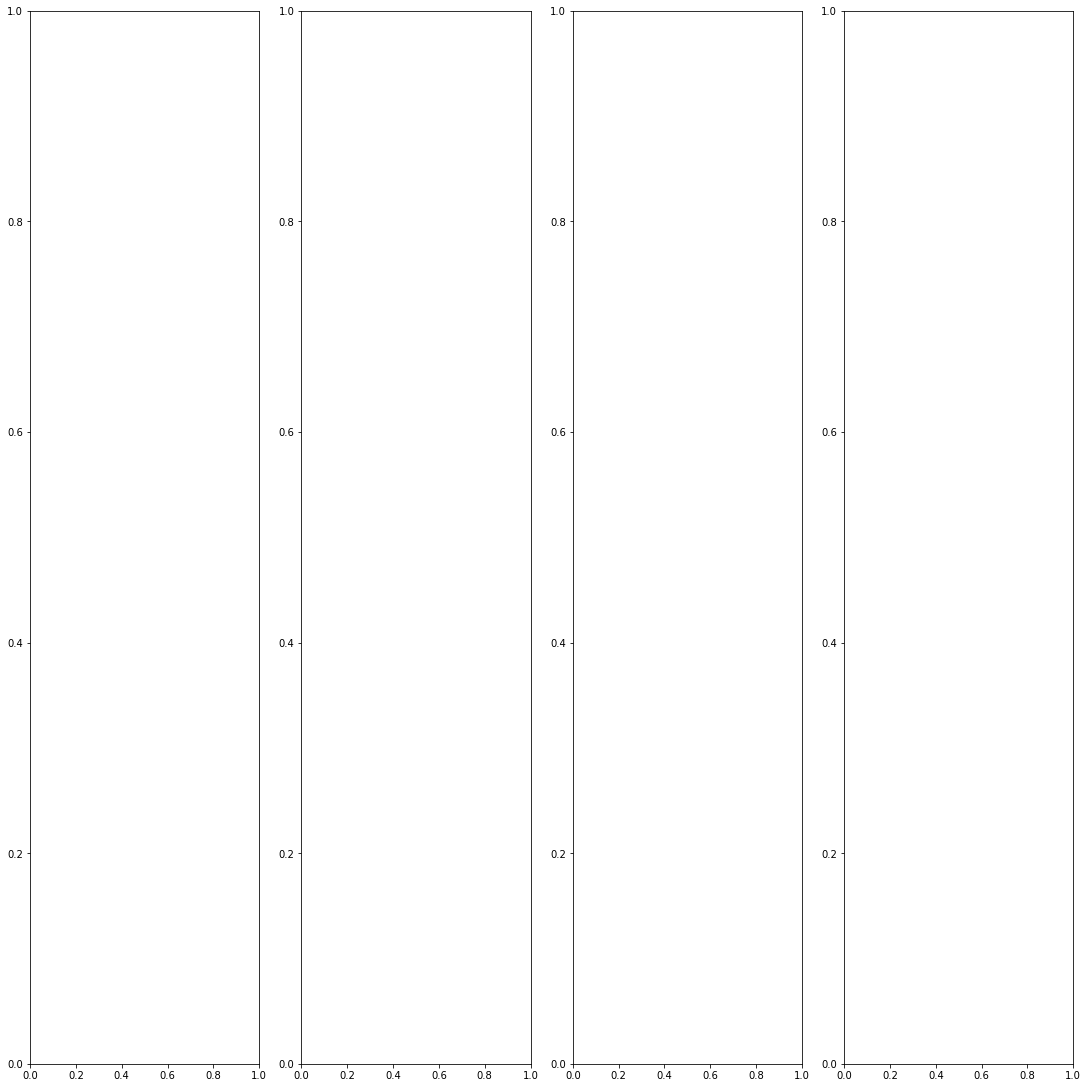

In [39]:
fig, axs = plt.subplots(1, 4, figsize=(15,15), constrained_layout=True)

for i in range(4):
    # function pre-defined are used to compute the prediction
    tf_image = T.read_image(random_image_path[i])
    prediction = predictor(tf_image)
    
    # eaxh image in shown with the prediction
    axs[i].set_title("Prediction = {}".format(prediction))
    axs[i].imshow(image.reshape(resize_shape[0],resize_shape[1],3))

In [40]:
predictor(image)

ValueError: height must be >= target + offset.